In [55]:
# Run order:
# 1) Load processed train/valid/test
# 2) Define num_cols + imputer
# 3) Train baseline model
# 4) Evaluate PR-AUC + Precision/Recall@K
# 5) Produce decision tables (valid/test)
# 6) Monitoring artifacts (drift + PSI)

In [1]:
import os
os.getcwd()

'/Users/amyliu/Desktop/fraud-detection-decisioning/notebooks'

In [1]:
# load the table
import pandas as pd
import numpy as np

train = pd.read_parquet("../data/processed/train.parquet")
print(train.shape)
train[["TransactionID","TransactionDT","isFraud"]].head()

(590540, 434)


,TransactionID,TransactionDT,isFraud
0,2987000,86400,0
1,2987001,86401,0
2,2987002,86469,0
3,2987003,86499,0
4,2987004,86506,0


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


# train table has 590540 rows, 434 columns,and includes label + time + id

EDA: 1. Fraud rate

In [3]:
train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [4]:
print(train["isFraud"].mean())

0.03499000914417313


Fraud rate is ~3.5%, so this is an imbalanced classification problem; PR-AUC and Precision@K matter.

2. Time drift

In [5]:
tmp = train[["TransactionDT","isFraud"]].copy()
tmp["dt_bin"] = pd.qcut(tmp["TransactionDT"], q=20, duplicates="drop")
rate_by_bin = tmp.groupby("dt_bin")["isFraud"].mean()

/var/folders/23/ffpfhtdx4wx901rhxgr55x4w0000gn/T/ipykernel_74639/2475449.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_by_bin = tmp.groupby("dt_bin")["isFraud"].mean()


In [6]:
rate_by_bin.reset_index(drop=True).head(), rate_by_bin.reset_index(drop=True).tail()

(0    0.028787
 1    0.026450
 2    0.023673
 3    0.016798
 4    0.035967
 Name: isFraud, dtype: float64,
 15    0.035087
 16    0.033224
 17    0.029465
 18    0.035357
 19    0.039591
 Name: isFraud, dtype: float64)

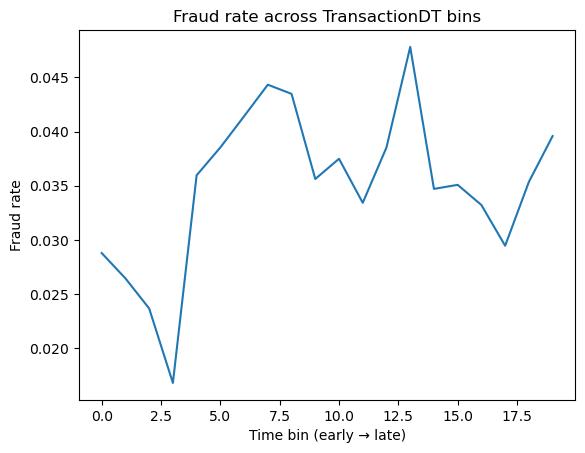

In [72]:
import matplotlib.pyplot as plt
plt.figure()
rate_by_bin.reset_index(drop=True).plot()
plt.title("Fraud rate across TransactionDT bins")
plt.xlabel("Time bin (early → late)")
plt.ylabel("Fraud rate")
plt.show()

plt.figure()
rate_by_bin.reset_index(drop=True).plot()
plt.title("Fraud rate across TransactionDT bins")
plt.xlabel("Time bin (early → late)")
plt.ylabel("Fraud rate")
plt.savefig("../reports/figures/fraud_rate_over_time.png", dpi=200, bbox_inches="tight")
plt.close()

In [59]:
import os
import matplotlib.pyplot as plt

os.makedirs("../reports/figures", exist_ok=True)  

plt.savefig("../reports/figures/fraud_rate_drift_test.png",
            dpi=200, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

Fraud rate drifts over time → time-based split is necessary.(~1.7% up to ~4.8%)

3. Missingness

In [8]:
missing_rate = train.isna().mean().sort_values(ascending=False)
missing_rate.head(20)

id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
id_03    0.887689
id_04    0.887689
D6       0.876068
id_33    0.875895
id_10    0.873123
dtype: float64

In [9]:
# too missing
(missing_rate > 0.95).sum(), (missing_rate > 0.99).sum()

(np.int64(9), np.int64(9))

Many features are sparse; for baseline we keep them with imputers, but later we may drop >95% missing columns.

4. categorical types

In [10]:
# How many categorical columns + cardinality
obj_cols = train.select_dtypes(include="object").columns
len(obj_cols), list(obj_cols[:20])

(31,
 ['ProductCD',
  'card4',
  'card6',
  'P_emaildomain',
  'R_emaildomain',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'id_12',
  'id_15',
  'id_16',
  'id_23',
  'id_27',
  'id_28'])

In [11]:
# check high-cardinality categories
cardinality = train[obj_cols].nunique(dropna=True).sort_values(ascending=False)
cardinality.head(15)

DeviceInfo       1786
id_33             260
id_31             130
id_30              75
R_emaildomain      60
P_emaildomain      59
ProductCD           5
id_34               4
card4               4
card6               4
id_15               3
id_23               3
M4                  3
M2                  2
DeviceType          2
dtype: int64

If some have huge unique counts (e.g., DeviceInfo): “One-hot may explode; prefer frequency encoding or limit categories.

5. identity coverage

In [12]:
for c in ["DeviceType", "DeviceInfo", "id_01", "id_12", "id_31", "id_33"]:
    if c in train.columns:
        print(c, "coverage =", 1 - train[c].isna().mean())

DeviceType coverage = 0.23844278118332374
DeviceInfo coverage = 0.20094489789006675
id_01 coverage = 0.24423917092830294
id_12 coverage = 0.24423917092830294
id_31 coverage = 0.23754868425508857
id_33 coverage = 0.12410505638906766


In [13]:
id_like = [c for c in train.columns if c.startswith("id_")] + ["DeviceType", "DeviceInfo"]
id_like = [c for c in id_like if c in train.columns]

identity_present = train[id_like].notna().any(axis=1).mean()
identity_present

np.float64(0.2442391709283029)

Only about ~20–25% of transactions have identity signals.
So identity data is sparse, but it can still be valuable because:
	•	when present, it can be highly predictive
	•	missingness itself can be informative (fraud/no-fraud patterns differ)

# Stage 2: Modling and decision

1. Time-based split

In [14]:
# comfirm the data sorted by time
train["TransactionDT"].is_monotonic_increasing

True

means already sorted

In [15]:
#split, ratio: 60/20/20
n = len(train)
i1 = int(n * 0.60)
i2 = int(n * 0.80)

train_df = train.iloc[:i1]
valid_df = train.iloc[i1:i2]
test_df  = train.iloc[i2:]

print(len(train_df), len(valid_df), len(test_df))

# for check
print("time max (train) vs min (valid):", train_df["TransactionDT"].max(), valid_df["TransactionDT"].min())
print("time max (valid) vs min (test):",  valid_df["TransactionDT"].max(), test_df["TransactionDT"].min())

print("fraud rates:", 
      train_df["isFraud"].mean(), 
      valid_df["isFraud"].mean(), 
      test_df["isFraud"].mean())

354324 118108 118108
time max (train) vs min (valid): 8745772 8745798
time max (valid) vs min (test): 12192842 12192900
fraud rates: 0.03383344057980831 0.03904053916754157 0.034409184813899145


size matches, no leakage (time boundaries), Fraud rate drift exists (time matters)

2. Baseline model

numeric-only first

In [16]:
exclude = ["isFraud", "TransactionID", "TransactionDT"]

X_train = train_df.drop(columns=exclude)
y_train = train_df["isFraud"]

X_valid = valid_df.drop(columns=exclude)
y_valid = valid_df["isFraud"]

num_cols = X_train.select_dtypes(include="number").columns
print("numeric feature count:", len(num_cols))

numeric feature count: 400


Then handling missing values

In [17]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="median")
Xtr = imp.fit_transform(X_train[num_cols])
Xva = imp.transform(X_valid[num_cols])

print("train matrix shape:", Xtr.shape)
print("valid matrix shape:", Xva.shape)

train matrix shape: (354324, 400)
valid matrix shape: (118108, 400)


Fit a tree model

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

clf.fit(Xtr, y_train)
print("trained")

trained


In [19]:
from sklearn.metrics import average_precision_score

p_valid = clf.predict_proba(Xva)[:, 1]

pr_auc = average_precision_score(y_valid, p_valid)
print("Validation PR-AUC:", pr_auc)

Validation PR-AUC: 0.5723447634265499


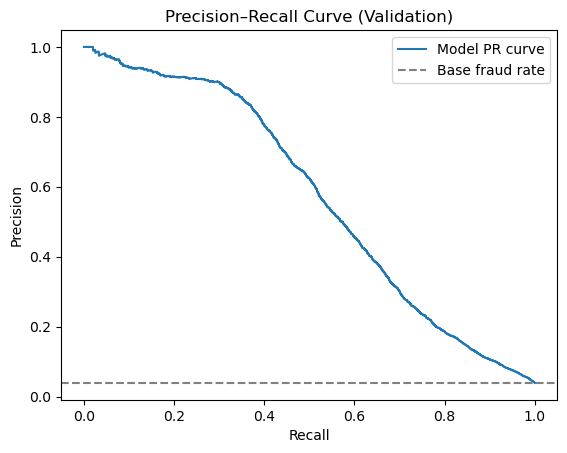

In [65]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_valid, p_valid)

plt.figure()
plt.plot(recall, precision, label="Model PR curve")
plt.axhline(y_valid.mean(), linestyle="--", color="gray", label="Base fraud rate")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.legend()
plt.show()

In [67]:
import os
os.makedirs("../reports/figures", exist_ok=True)

plt.figure()
plt.plot(recall, precision, label="Model PR curve")
plt.axhline(y_valid.mean(), linestyle="--", color="gray", label="Base fraud rate")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.legend()
plt.savefig("../reports/figures/pr_curve_valid.png", dpi=200, bbox_inches="tight")
plt.close()

Precision @ k

In [24]:
K = 10000
idx_topk = np.argsort(-p_valid)[:K]
fraud_in_topk = y_valid.iloc[idx_topk].sum()
precision_at_k = y_valid.iloc[idx_topk].mean()
precision_at_k

np.float64(0.3174)

Recall @ k

In [25]:
total_fraud = y_valid.sum()
total_fraud
recall_at_k = fraud_in_topk / total_fraud
float(recall_at_k)

0.6883539362394274

Two-tier decisioning

Tier 1 — Manual Review
1. Top K1 = 1,000 highest-risk transactions → manual review queue
2. Goal: very high precision

Tier 2 — Step-up Verification

1.	Next K2 = 10,000 (or “up to 10,000 total”) → OTP/3DS/hold shipment/extra verification
2.  Goal: catch more fraud while controlling customer friction



In [26]:
for K0 in [50, 100, 200, 500, 1000, 10000]:
    idx = np.argsort(-p_valid)[:K0]
    prec = float(y_valid.iloc[idx].mean())
    rec  = float(y_valid.iloc[idx].sum() / y_valid.sum())
    print("VALID K0", K0, "precision:", prec, "recall:", rec)

VALID K0 50 precision: 1.0 recall: 0.010843634786380394
VALID K0 100 precision: 0.99 recall: 0.02147039687703318
VALID K0 200 precision: 0.98 recall: 0.04250704836261115
VALID K0 500 precision: 0.942 recall: 0.10214703968770332
VALID K0 1000 precision: 0.915 recall: 0.19843851659076123
VALID K0 10000 precision: 0.3174 recall: 0.6883539362394274


Top-10,000 step-up queue achieves 31.7% precision (~8× lift over the 3.9% base rate) while capturing 68.8% of all fraud on validation.

Score at rank K

Logic:

	•if score ≥ t_decline → in top 100 → decline
    •else if score ≥ t_review → ranks 101–1000 → review
	•else if score ≥ t_stepup → ranks 1001–10000 → step_up
	•else → approve

In [27]:
K0, K1, K2 = 100, 1000, 10000
scores_sorted = np.sort(p_valid)[::-1]   # high → low

t_decline = scores_sorted[K0-1]   # cutoff for top 100    
t_review = scores_sorted[K1-1]   # cutoff for top 1000
t_stepup = scores_sorted[K2-1]   # cutoff for top 10000

t_decline, t_review, t_stepup

(np.float64(0.990607590335304),
 np.float64(0.8915079148725272),
 np.float64(0.057336531098498886))

In [28]:
import pandas as pd
import numpy as np
import os

decisions = pd.DataFrame({
    "TransactionID": valid_df["TransactionID"].values,
    "score": p_valid
})

decisions["rank"] = decisions["score"].rank(method="first", ascending=False).astype(int)

decisions["action"] = np.where(
    decisions["score"] >= t_decline, "decline",
    np.where(
        decisions["score"] >= t_review, "review",
        np.where(decisions["score"] >= t_stepup, "step_up", "approve")
    )
)
n = len(decisions)

# quick sanity checks: exactly 1000 review, 9000 step_up (total 10000), rest approve
n = len(decisions)
print("total:", n)
print("decline:", (decisions["action"]=="decline").sum())
print("review:", (decisions["action"]=="review").sum())
print("step_up:", (decisions["action"]=="step_up").sum())
print("approve:", (decisions["action"]=="approve").sum())
 
decisions.head()

total: 118108
decline: 100
review: 900
step_up: 9000
approve: 108108


,TransactionID,score,rank,action
0,3341324,0.011472,51007,approve
1,3341325,0.033644,16504,approve
2,3341326,0.003095,107528,approve
3,3341327,0.005696,85100,approve
4,3341328,0.008778,65155,approve


Test this 

In [29]:
exclude = ["isFraud", "TransactionID", "TransactionDT"]

X_test = test_df.drop(columns=exclude)
y_test = test_df["isFraud"]

Xte = imp.transform(X_test[num_cols])   # no fit! only transform
print(Xte.shape, y_test.shape)

(118108, 400) (118108,)


In [30]:
# get the test score
p_test = clf.predict_proba(Xte)[:, 1]
p_test[:5]

array([0.01124469, 0.00469198, 0.51642143, 0.2670625 , 0.00593856])

In [31]:
# Evaluation
def precision_recall_at_k(y_true, scores, K):
    idx = np.argsort(-scores)[:K]
    precision = float(y_true.iloc[idx].mean())
    recall = float(y_true.iloc[idx].sum() / y_true.sum())
    return precision, recall

for K in [100, 1000, 10000]:
    p, r = precision_recall_at_k(y_test, p_test, K)
    print("TEST", K, "precision:", p, "recall:", r)

print("Test base rate:", float(y_test.mean()))

TEST 100 precision: 1.0 recall: 0.024606299212598427
TEST 1000 precision: 0.9 recall: 0.22145669291338582
TEST 10000 precision: 0.243 recall: 0.5979330708661418
Test base rate: 0.034409184813899145


High precision at the top, good recall at larger K.

In [32]:
KO, K1, K2 = 100, 1000, 10000

decisions_test = pd.DataFrame({
    "TransactionID": test_df["TransactionID"].values,
    "score": p_test
}).sort_values("score", ascending=False).reset_index(drop=True)

decisions_test["rank"] = np.arange(1, len(decisions_test)+1)

decisions_test["action"] = np.where(
    decisions_test["rank"] <= K0, "decline",
    np.where(decisions_test["rank"] <= K1, "review",
    np.where(decisions_test["rank"] <= K2, "step_up", "approve"))
)

print("counts:",
      (decisions_test["action"]=="decline").sum(),
      (decisions_test["action"]=="review").sum(),
      (decisions_test["action"]=="step_up").sum(),
      (decisions_test["action"]=="approve").sum())

decisions_test.to_csv("../reports/sample_decisions_test_rank_policy.csv", index=False)
print("saved: reports/sample_decisions_test_rank_policy.csv")

counts: 100 900 9000 108108
saved: reports/sample_decisions_test_rank_policy.csv


In [33]:
t0_test = decisions_test.loc[K0-1, "score"]
t1_test = decisions_test.loc[K1-1, "score"]
t2_test = decisions_test.loc[K2-1, "score"]
t0_test, t1_test, t2_test

(np.float64(0.9892054938956216),
 np.float64(0.7998094758870729),
 np.float64(0.06496093758287563))

In [34]:
from sklearn.metrics import average_precision_score
print("Test PR-AUC:", average_precision_score(y_test, p_test))

Test PR-AUC: 0.4623303114942475


Performance decreases on the future (test) slice due to temporal drift, but the model retains strong ranking power (Test PR-AUC 0.462 vs 3.44% base rate).

In [35]:
import json, os

summary = {
  "validation": {
    "base_rate": float(y_valid.mean()),
    "pr_auc": float(average_precision_score(y_valid, p_valid)),
    "K_decline": 100,
    "K_review": 1000,
    "K_step_up_total": 10000,
    "precision@100": 1.0,
    "recall@100": 0.010843634786380394,
    "precision@1000": 0.915,
    "recall@1000": 0.19843851659076123,
    "precision@10000": 0.3174,
    "recall@10000": 0.6883539362394274,
    "t_decline_rank": float(t_decline),
    "t_review_rank": float(t_review),
    "t_step_up_rank": float(t_stepup)
  },
  "test": {
    "base_rate": float(y_test.mean()),
    "pr_auc": 0.4623303114942475,
    "precision@100": 1.0,
    "recall@100": 0.024606299212598427,
    "precision@1000": 0.9,
    "recall@1000": 0.22145669291338582,
    "precision@10000": 0.243,
    "recall@10000": 0.5979330708661418,
    "t_decline_rank": 0.9892054938956216,
    "t_review_rank": 0.7998094758870729,
    "t_step_up_rank": 0.06496093758287563
  },
  "notes": "Time-based split. Numeric-only baseline. Capacity-locked (rank-based) policy shown; fixed-threshold policy causes queue volume drift."
}

os.makedirs("../reports", exist_ok=True)
with open("../reports/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("saved: reports/metrics_summary.json")

saved: reports/metrics_summary.json


In [36]:
average_precision_score(y_valid, p_valid)

0.5723447634265499

# Stage 3: Monitoring

1. Create a monitoring table

In [39]:
mon = test_df[["TransactionDT"]].copy()
mon["score"] = p_test
mon.head()

,TransactionDT,score
472432,12192900,0.011245
472433,12192911,0.004692
472434,12192913,0.516421
472435,12193040,0.267062
472436,12193199,0.005939


2. Create time bins

In [40]:
mon["time_bin"] = pd.qcut(mon["TransactionDT"], q=20, labels=False, duplicates="drop")
mon["time_bin"].value_counts().sort_index().head()

time_bin
0    5906
1    5905
2    5906
3    5905
4    5905
Name: count, dtype: int64

3. Score drift plot

In [41]:
score_by_bin = mon.groupby("time_bin")["score"].mean()
score_by_bin

time_bin
0     0.030891
1     0.025220
2     0.027484
3     0.030807
4     0.027825
5     0.027174
6     0.034731
7     0.027905
8     0.027276
9     0.033346
10    0.042039
11    0.028904
12    0.029948
13    0.032041
14    0.045039
15    0.045298
16    0.034296
17    0.038212
18    0.034899
19    0.035124
Name: score, dtype: float64

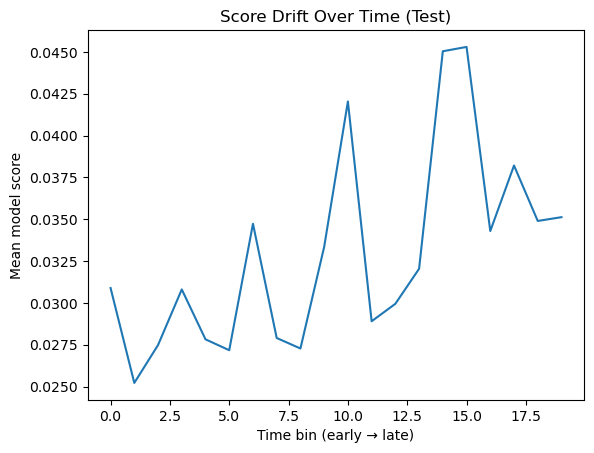

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(score_by_bin.index, score_by_bin.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("Mean model score")
plt.title("Score Drift Over Time (Test)")
plt.show()

In [43]:
import os
os.makedirs("../reports/figures", exist_ok=True)
plt.figure()
plt.plot(score_by_bin.index, score_by_bin.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("Mean model score")
plt.title("Score Drift Over Time (Test)")
plt.savefig("../reports/figures/score_drift_test.png", dpi=200, bbox_inches="tight")
plt.close()

The model is seeing later transactions as “riskier” on average.

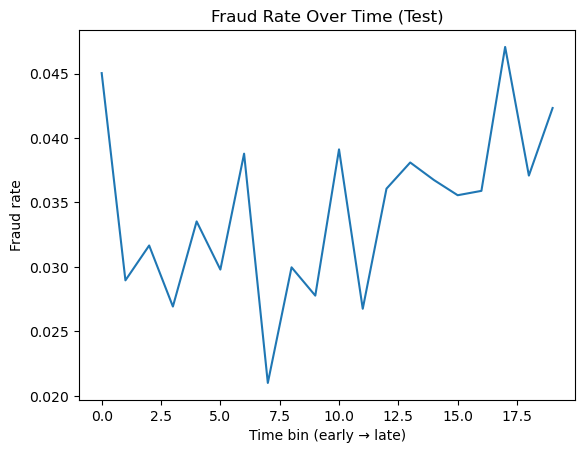

In [69]:
mon2 = test_df[["TransactionDT", "isFraud"]].copy()
mon2["time_bin"] = pd.qcut(mon2["TransactionDT"], q=20, labels=False, duplicates="drop")

fraud_by_bin = mon2.groupby("time_bin")["isFraud"].mean()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fraud_by_bin.index, fraud_by_bin.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("Fraud rate")
plt.title("Fraud Rate Over Time (Test)")
plt.show()

os.makedirs("../reports/figures", exist_ok=True)
plt.figure()
plt.plot(fraud_by_bin.index, fraud_by_bin.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("Fraud rate")
plt.title("Fraud Rate Over Time (Test)")
plt.savefig("../reports/figures/fraud_rate_over_time.png", dpi=200, bbox_inches="tight")
plt.close()

	• If fraud rate rises in the same bins where mean score rises → model is tracking reality (good).  
	• If fraud rate is flat but scores rise → drift/pipeline issue or model instability (needs investigation).

The score drift is largely explained by real label drift (fraud prevalence changes over time), not just “model going crazy."
(Scores drift upward in later periods, consistent with an increase in observed fraud rate.)

In [53]:
import os
import matplotlib.pyplot as plt

os.makedirs("../reports/figures", exist_ok=True)

plt.figure()
plt.plot(fraud_by_bin.index, fraud_by_bin.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("Fraud rate")
plt.title("Fraud Rate Over Time (Test)")
plt.savefig("../reports/figures/fraud_rate_drift_test.png", dpi=200, bbox_inches="tight")
plt.close()

print("saved: reports/figures/fraud_rate_drift_test.png")

saved: reports/figures/fraud_rate_drift_test.png


4. PSI

Using the standard PSI rule-of-thumb:
	•	PSI < 0.10 = small drift
	•	0.10–0.25 = moderate drift
	•	0.25 = large drift

In [54]:
import numpy as np
import pandas as pd

def psi(expected, actual, buckets=10, eps=1e-6):
    cuts = np.quantile(expected, np.linspace(0, 1, buckets + 1))
    cuts[0], cuts[-1] = -np.inf, np.inf
    e = np.histogram(expected, bins=cuts)[0] / len(expected)
    a = np.histogram(actual, bins=cuts)[0] / len(actual)
    e = np.clip(e, eps, None)
    a = np.clip(a, eps, None)
    return float(np.sum((a - e) * np.log(a / e)))

ref = mon.loc[mon["time_bin"] == mon["time_bin"].min(), "score"].values

psi_by_bin = {}
for b in sorted(mon["time_bin"].unique()):
    cur = mon.loc[mon["time_bin"] == b, "score"].values
    psi_by_bin[int(b)] = psi(ref, cur)

psi_series = pd.Series(psi_by_bin).sort_index()
psi_series.head(), psi_series.max()

(0    0.000000
 1    0.023738
 2    0.005733
 3    0.002212
 4    0.029882
 dtype: float64,
 np.float64(0.06727601895757541))

The score distribution is pretty stable across time bins

In [51]:
psi_series.to_csv("../reports/psi_by_timebin_test.csv", index_label="time_bin")

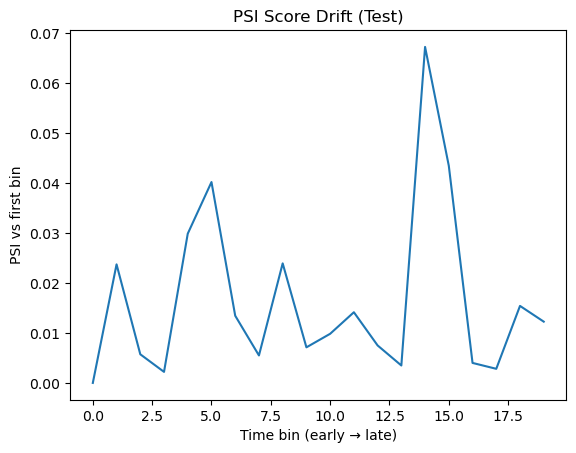

In [52]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(psi_series.index, psi_series.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("PSI vs first bin")
plt.title("PSI Score Drift (Test)")
plt.show()

plt.figure()
plt.plot(psi_series.index, psi_series.values)
plt.xlabel("Time bin (early → late)")
plt.ylabel("PSI vs first bin")
plt.title("PSI Score Drift (Test)")
plt.savefig("../reports/figures/psi_score_drift_test.png", dpi=200, bbox_inches="tight")
plt.close()

We observe mild temporal variation in mean score, consistent with changes in fraud rate, while PSI indicates only small distribution drift.

In [57]:
summary["test"]["max_psi_score_drift"] = float(psi_series.max())
with open("../reports/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("updated metrics_summary.json with max PSI")

updated metrics_summary.json with max PSI
